In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/styleTransfer/LinearStyleTransfer

/content/drive/My Drive/Colab Notebooks/styleTransfer/LinearStyleTransfer


In [ ]:
!zip -r /content/file.zip ./

  adding: README.md (deflated 61%)
  adding: data/ (stored 0%)
  adding: data/content/ (stored 0%)
  adding: data/content/chicago.png (deflated 0%)
  adding: data/content/buildings/ (stored 0%)
  adding: data/content/buildings/xihu_test_2.0000.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0001.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0002.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0003.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0004.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0005.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0006.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0007.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0008.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0009.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0010.png (deflated 0%)
  adding: data/content/buildings/xihu_test_2.0011.png (def

In [ ]:
from google.colab import files
files.download("/content/file.zip")

In [ ]:
#!pip install torch==1.4.0 torchvision==0.5.0

In [ ]:
import os
import torch
from PIL import Image
from libs.Loader import Dataset
from libs.Matrix import MulLayer
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from libs.utils import print_options
from libs.models import encoder3,encoder4, encoder5
from libs.models import decoder3,decoder4, decoder5

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
class Opt(object):
  def __init__(self):
    self.vgg_dir = 'models/vgg_r31.pth' # pre-trained encoder path
    self.decoder_dir = 'models/dec_r31.pth' # pre-trained decoder path
    self.matrix_dir = "models/r31.pth" # path to pre-trained model
    self.style = "data/style/rpc.jpg" # path to style image
    self.content = "data/content/rpc_1.jpg" # path to content image
    self.loadSize = 512 # scale image size
    self.layer = "r31" # features of which layer to transform
    self.outf = "output/" # output folder

In [ ]:
# PREPARATIONS
opt = Opt()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print_options(opt)

os.makedirs(opt.outf,exist_ok=True)
cudnn.benchmark = True

----------------- Options ---------------
                  content: data/content/rpc_1.jpg        
              decoder_dir: models/dec_r31.pth            
                    layer: r31                           
                 loadSize: 512                           
               matrix_dir: models/r31.pth                
                     outf: output/                       
                    style: data/style/rpc.jpg            
                  vgg_dir: models/vgg_r31.pth            
----------------- End -------------------


In [ ]:
# MODEL
if(opt.layer == 'r31'):
    vgg = encoder3()
    dec = decoder3()
elif(opt.layer == 'r41'):
    vgg = encoder4()
    dec = decoder4()
matrix = MulLayer(layer=opt.layer)

vgg.load_state_dict(torch.load(opt.vgg_dir))
dec.load_state_dict(torch.load(opt.decoder_dir))
matrix.load_state_dict(torch.load(opt.matrix_dir, map_location=device))
vgg.to(device)
dec.to(device)
matrix.to(device)

MulLayer(
  (snet): CNN(
    (convs): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (fc): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (cnet): CNN(
    (convs): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (fc): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (compress): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
  (unzip): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
)

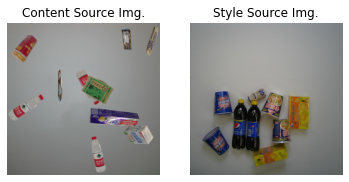

In [ ]:
# DATA
def loadImg(imgPath):
    img = Image.open(imgPath).convert('RGB')
    transform = transforms.Compose([
                transforms.Resize(opt.loadSize),
                transforms.ToTensor()])
    return transform(img)

# CHANGE DEFALTE CONTENT AND STYLE
# opt.content = '../..'
# opt.style = '../..'

styleV = loadImg(opt.style).unsqueeze(0).to(device)
contentV = loadImg(opt.content).unsqueeze(0).to(device)
contentName = os.path.basename(opt.content).split('.')[0]
styleName = os.path.basename(opt.style).split('.')[0]

f, axarr = plt.subplots(1,2)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].set_title('Content Source Img.')
axarr[1].set_title('Style Source Img.')
axarr[0].imshow(Image.open(opt.content))
axarr[1].imshow(Image.open(opt.style))
plt.show()

<Figure size 432x288 with 0 Axes>

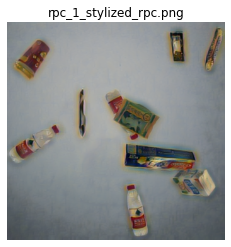

In [ ]:
# TRANSFER
with torch.no_grad():
    sF = vgg(styleV)
    cF = vgg(contentV)

    if(opt.layer == 'r41'):
        feature,transmatrix = matrix(cF[opt.layer],sF[opt.layer])
    else:
        feature,transmatrix = matrix(cF,sF)
        transfer = dec(feature)

transfer = transfer.clamp(0,1).squeeze(0).data.cpu().numpy()
transfer = transfer.transpose((1,2,0))

plt.figure()
f, ax= plt.subplots(1, 1)
ax.axis('off')
ax.set_title('%s_stylized_%s.png'%(contentName,styleName))
plt.imshow(transfer)
plt.show()

In [ ]:
print(os.path.basename(opt.content))

rpc_1.jpg
